In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import KFold
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model


data_dir = '/home/adri/Documents/Moodscape/New/archive'
batch_size = 64
img_height = 48
img_width = 48

# Load training datasets
train_dir = os.path.join(data_dir, 'train')
train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

# Load test datasets
test_dir = os.path.join(data_dir, 'test')
test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Combine datasets
combined_dataset = train_dataset.concatenate(test_dataset)

# Convert dataset to numpy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

images, labels = dataset_to_numpy(combined_dataset)

2024-06-12 18:43:04.342976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 18:43:05.241958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


2024-06-12 18:43:07.569749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 18:43:07.570448: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-12 18:43:08.469542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-06-12 18:43:50.276866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


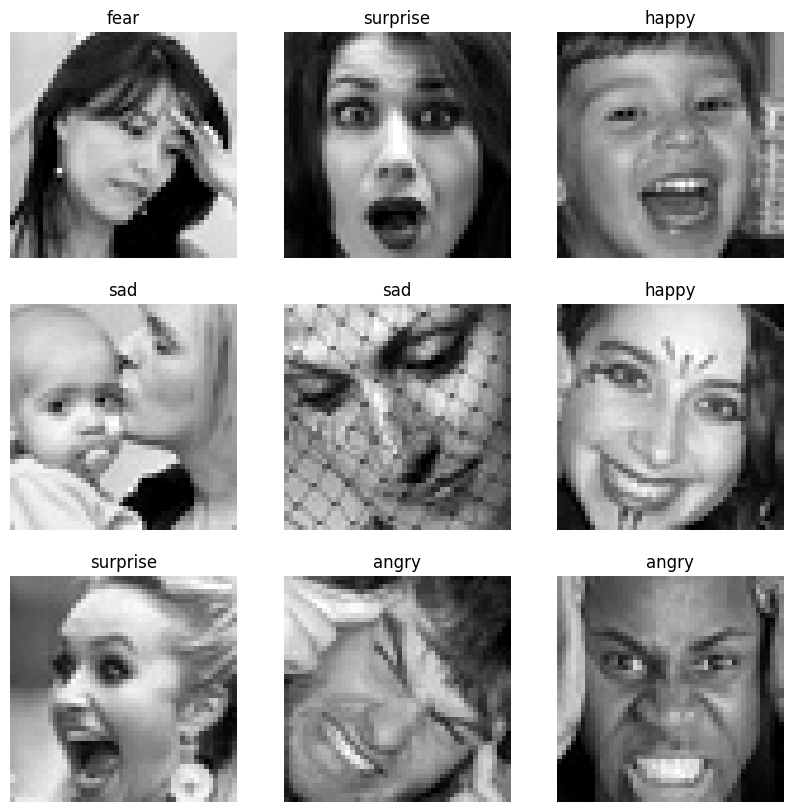

In [2]:


# Function to display a batch of images with labels
def display_batch(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Define class names (assumed based on typical emotion labels)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Get a batch of images and labels
for image_batch, label_batch in train_dataset.take(1):
    display_batch(image_batch.numpy(), label_batch.numpy(), class_names)


In [3]:
# Define the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [4]:
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True)

fold_no = 1
for train_index, val_index in kf.split(images):
    print(f'Training fold {fold_no}...')
    
    x_train, x_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    
    model = create_model()
    
    model.fit(train_dataset, epochs=10, validation_data=val_dataset)
    
    fold_no += 1

# Save the trained model with a valid file extension
model.save('facial_expression_model.keras')

Training fold 1...
Epoch 1/10


/home/adri/Documents/Moodscape/New/environment/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.2649 - loss: 1.7894 - val_accuracy: 0.4277 - val_loss: 1.4989
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.4295 - loss: 1.4707 - val_accuracy: 0.4848 - val_loss: 1.3515
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.4970 - loss: 1.3224 - val_accuracy: 0.5171 - val_loss: 1.2744
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5336 - loss: 1.2312 - val_accuracy: 0.5350 - val_loss: 1.2267
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5604 - loss: 1.1672 - val_accuracy: 0.5411 - val_loss: 1.2005
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5831 - loss: 1.1054 - val_accuracy: 0.5527 - val_loss: 1.1855
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6035 - loss: 1.0568 - val_accuracy: 0.5478 - val_loss: 1.1992
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.6225 - loss: 1.0038 - val_accurac

In [7]:

# Load the trained model
model = load_model('facial_expression_model.keras')

# Define emotion labels
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Check if GUI support is available
try:
    cv2.namedWindow("Facial Expression Detection")
    headless = False
except cv2.error as e:
    print("OpenCV GUI support not available, using headless mode.")
    headless = True

# Initialize webcam
cap = cv2.VideoCapture(0)

# Define a function to capture and process frames
def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_gray = cv2.resize(gray, (48, 48))
    normalized_gray = resized_gray / 255.0
    input_image = np.expand_dims(normalized_gray, axis=0)
    input_image = np.expand_dims(input_image, axis=-1)
    
    # Perform inference
    predictions = model.predict(input_image)
    predicted_label = emotion_labels[np.argmax(predictions)]
    
    # Display results
    cv2.putText(frame, predicted_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    if headless:
        # Save frame to disk in headless mode
        cv2.imwrite('output.jpg', frame)
    else:
        # Display the resulting frame
        cv2.imshow('Facial Expression Detection', frame)

# Process frames
try:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break
        
        # Process the captured frame
        process_frame(frame)
        
        if not headless:
            # Check for 'q' key press to exit loop
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            # In headless mode, process frames for a fixed duration
            # Adjust the number of iterations as needed
            for _ in range(10):
                ret, frame = cap.read()
                if not ret:
                    break
                process_frame(frame)

finally:
    # Release the capture
    cap.release()
    if not headless:
        cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 